In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Let's load in the familiar air passengers dataset
ts = pd.read_csv('AirPassengers.csv')
ts.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# first things first, change index to datetime
ts['Month'] = pd.to_datetime(ts['Month'])
ts.set_index('Month', inplace=True)
ts.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


/Users/johnmaxbarry/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


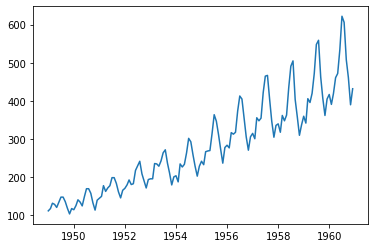

In [4]:
import matplotlib.pyplot as plt
# Plot the original series
plt.plot(ts)

What types of patterns do you see here?
- Trend?
- Seasonality?
- Increased variance?
- Cyclical?

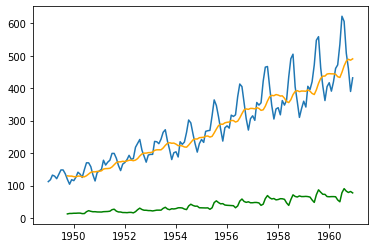

In [5]:
# Let's plot the original series along with a rolling mean and rolling std
plt.plot(ts)
plt.plot(ts.rolling(10).mean(), 'orange')
plt.plot(ts.rolling(10).std(),'green')


Both the mean and standard deviation look to have trends, 
or in other words, they are not stationary.

We can do visual checks for sationarity, but we also have the Dickey-Fuller test.

In [6]:
# The p-value is .99, which does not pass the threshold for rejecting the null hypothesis
# that the series is stationary
from statsmodels.tsa.stattools import adfuller
adfuller(ts['#Passengers'])

(0.8153688792060544,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

There are different ways to transform the series in an attempt to make it stationary:

In [7]:
# Let's try resampling
ts.resample('W').mean()

,#Passengers
Month,
1949-01-02,112.0
1949-01-09,NaN
1949-01-16,NaN
1949-01-23,NaN
1949-01-30,NaN
...,...
1960-11-06,390.0
1960-11-13,NaN
1960-11-20,NaN


In [8]:
# That leads to a lot of nan's, so we can backfill or forward fill
# This is not a good idea with data such as this. 
# Treat this as an example of filling. You will most likely have to use the methods ffill and bfill
# because of missing data, and na's are all over the place.
 
ts.resample('W').mean().ffill()

,#Passengers
Month,
1949-01-02,112.0
1949-01-09,112.0
1949-01-16,112.0
1949-01-23,112.0
1949-01-30,112.0
...,...
1960-11-06,390.0
1960-11-13,390.0
1960-11-20,390.0


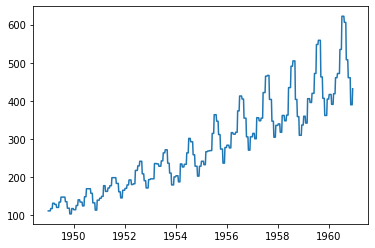

In [9]:
# Resampling by the week and filling doesn't do much
plt.plot(ts.resample('W').mean().ffill())

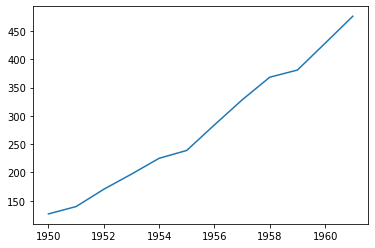

In [10]:
# Let's try resampling with a year period
plt.plot(ts.resample('Y').mean())

In [11]:
# that smoothed things out, but there is still an upward trend.
ts_y = ts.resample('Y').mean()

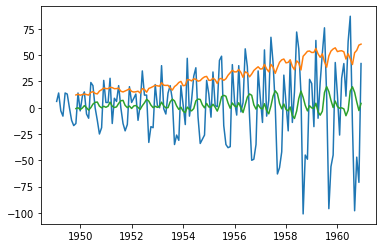

In [12]:
# Let's try differencing
# First order differencing removes the trend, but there is still increasing variance and seasonality
plt.plot(ts.diff(1))
plt.plot(ts.diff(1).rolling(10).std())
plt.plot(ts.diff(1).rolling(10).mean())

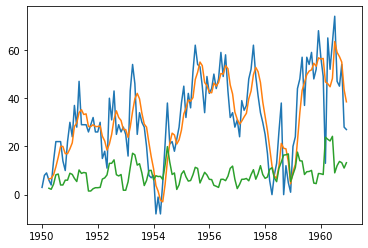

In [13]:
#let's try differencing with a window of 12, i.e. a year.
plt.plot(ts.diff(12))
plt.plot(ts.diff(12).rolling(4).mean())
plt.plot(ts.diff(12).rolling(4).std())

In [14]:
# That looks stationary.  Let's test that with Dickey Fuller
print(adfuller(ts.diff(12)['#Passengers'].dropna()))
print('The test p-value of .011 confirms our visuals')

(-3.3830207264924805, 0.011551493085514982, 1, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 919.527129208137)
The test p-value of .011 confirms our visuals


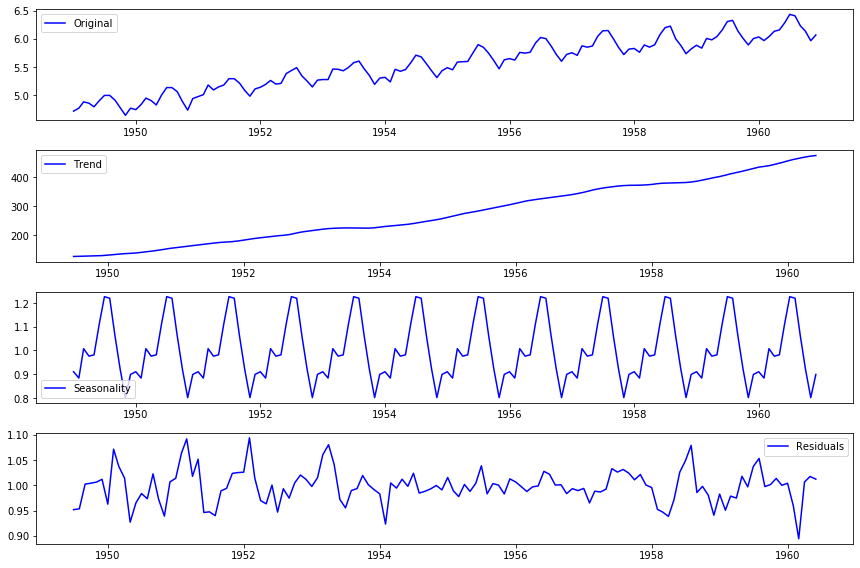

In [15]:
# We can also use decompose to get different stationary timeseries 
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(ts), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [16]:
adfuller(residual['#Passengers'].dropna())

(-7.415924640885233,
 6.936028992598598e-11,
 7,
 124,
 {'1%': -3.484219653271961,
  '5%': -2.885145235641637,
  '10%': -2.579359138917794},
 -513.429581554826)

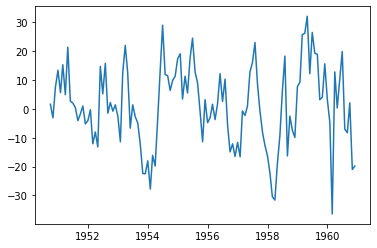

In [17]:
# We can also produce a similar result by remove seasonality from the rolling mean
differenced_rolling_mean = (ts - ts.rolling(10).mean()).diff(12).dropna()

plt.plot(differenced_rolling_mean['#Passengers'])

In [20]:
# That looks fairly stationary, lets confirm with DickyFuller
adfuller(differenced_rolling_mean['#Passengers'])

(-5.14735382093749,
 1.124992950144213e-05,
 0,
 122,
 {'1%': -3.4851223522012855,
  '5%': -2.88553750045158,
  '10%': -2.5795685622144586},
 838.4980033234301)

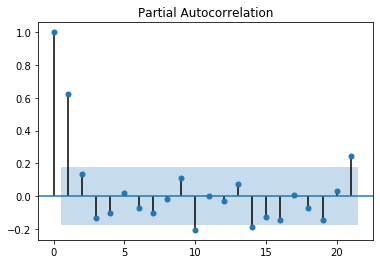

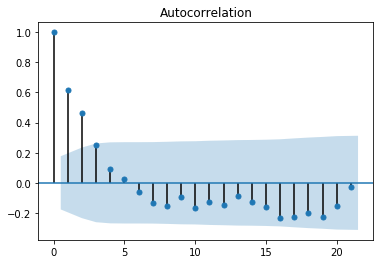

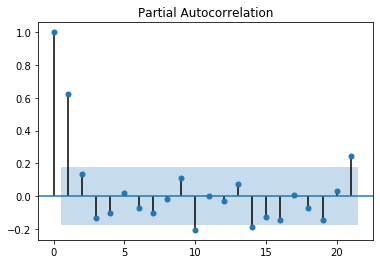

In [21]:
# Once we have stationary data, we can use the ARMA models.
# We use ACF and pACF plots to determine the parameters of the model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(differenced_rolling_mean.dropna())
plot_pacf(differenced_rolling_mean.dropna())

## AR formula
$Y_t = \mu + \phi * Y_{t-1}+\epsilon_t$

## MA formula

$Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$

In [22]:
# Looking at the above plot, it looks like the pACF suggests a 1 for the AR term
# and the ACF suggests a 1 for the MA term

from statsmodels.tsa.arima_model import ARMA

arma = ARMA(differenced_rolling_mean, [1,2])
results_arma = arma.fit()
print(results_arma.summary())

                              ARMA Model Results                              
Dep. Variable:            #Passengers   No. Observations:                  123
Model:                     ARMA(1, 2)   Log Likelihood                -464.251
Method:                       css-mle   S.D. of innovations             10.515
Date:                Fri, 03 Apr 2020   AIC                            938.503
Time:                        14:31:09   BIC                            952.564
Sample:                    10-01-1950   HQIC                           944.214
                         - 12-01-1960                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7060      2.528      0.279      0.780      -4.248       5.660
ar.L1.#Passengers     0.5058      0.178      2.835      0.005       0.156       0.855
ma.L1.#Passengers     0.

/Users/johnmaxbarry/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [23]:
results_arma.predict()

1950-10-01     0.705968
1950-11-01     1.263276
1950-12-01    -1.175854
1951-01-01     3.400762
1951-02-01     9.968306
                ...    
1960-08-01    10.967648
1960-09-01    -0.004947
1960-10-01    -9.374936
1960-11-01    -0.437333
1960-12-01    -7.930653
Freq: MS, Length: 123, dtype: float64

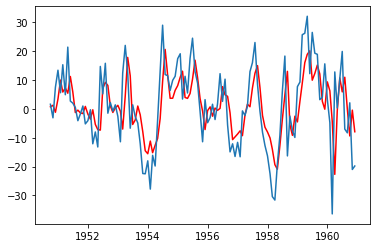

In [24]:
# we can add see how well our model performs by adding back the differenced rolling mean
plt.plot(results_arma.predict(), c='red')
plt.plot(differenced_rolling_mean)

In [25]:
# Let's try running it on the residuals
arma = ARMA(residual['#Passengers'].dropna(), [1,1])
res_arma = arma.fit()
print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:            #Passengers   No. Observations:                  132
Model:                     ARMA(1, 1)   Log Likelihood                 273.883
Method:                       css-mle   S.D. of innovations              0.030
Date:                Fri, 03 Apr 2020   AIC                           -539.766
Time:                        14:31:10   BIC                           -528.235
Sample:                    07-01-1949   HQIC                          -535.080
                         - 06-01-1960                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.9981      0.004    230.397      0.000       0.990       1.007
ar.L1.#Passengers     0.3529      0.152      2.326      0.022       0.056       0.650
ma.L1.#Passengers     0.

/Users/johnmaxbarry/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [26]:
y_pred = res_arma.predict()+seasonal['#Passengers']['1949-07-01':'1960-06-01']+trend['#Passengers']['1949-07-01':'1960-06-01']
y_true = ts['1949-07-01':'1960-06-01']['#Passengers']

In [27]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true, y_pred)

1675.8137097069718

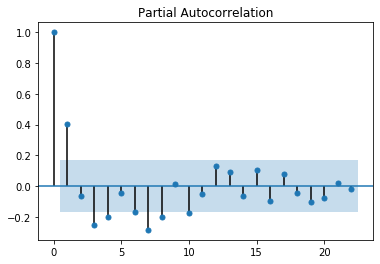

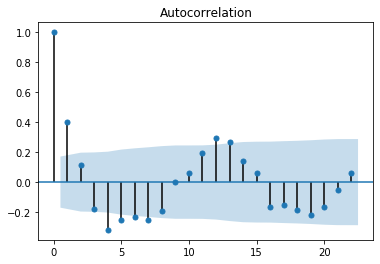

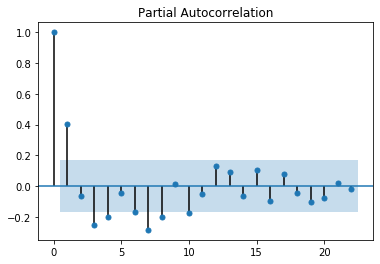

In [28]:
plot_acf(residual['#Passengers'].dropna())
plot_pacf(residual['#Passengers'].dropna())

In [29]:
# ARIMA models do not require the timeseries to be stationary.
# Looking at the parameters, the inputs require p,d,q
# p = AR term
# d = differencing
# q = MA term
from statsmodels.tsa.arima_model import ARIMA

arima = ARIMA()

TypeError: __new__() missing 2 required positional arguments: 'endog' and 'order'

Text(0.5, 1.0, 'PACF: This shows significant lags all the way up to 15')

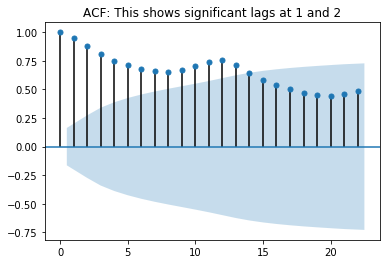

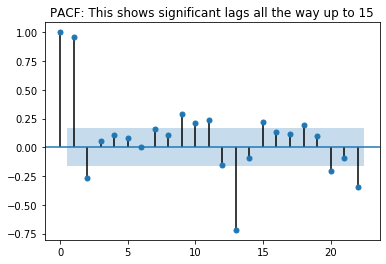

In [30]:
# Look at the pACF and ACF to determin  p and q
plot_acf(ts['#Passengers'])
plt.title('ACF: This shows significant lags at 1 and 2')
plot_pacf(ts["#Passengers"])
plt.title('PACF: This shows significant lags all the way up to 15')

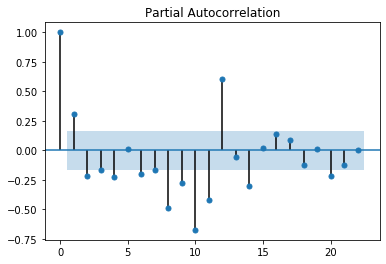

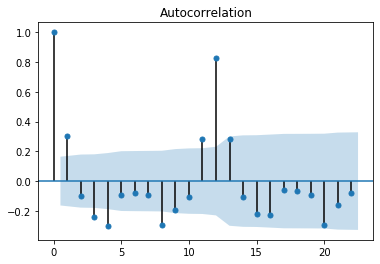

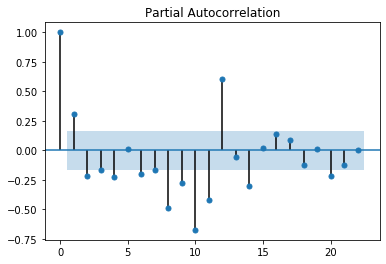

In [31]:
plot_acf(ts['#Passengers'].diff(1).dropna())
plot_pacf(ts["#Passengers"].diff(1).dropna())

In [32]:
# A reasonable start to the ARIMA model is 
# 5 for the AR term (p)
# 1 for the differencing term (d)
# 1 for the MA term
arima = ARIMA(ts['#Passengers'], [5,1,1])


/Users/johnmaxbarry/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/johnmaxbarry/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [33]:
# We can fit the model with disp=0 to hide errors, and look at the summary to see AIC/BIC
arima_fit = arima.fit(disp=0)
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -673.777
Method:                       css-mle   S.D. of innovations             26.655
Date:                Fri, 03 Apr 2020   AIC                           1363.554
Time:                        14:31:12   BIC                           1387.256
Sample:                    02-01-1949   HQIC                          1373.185
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.6732      0.200     13.336      0.000       2.280       3.066
ar.L1.D.#Passengers     1.0102      0.090     11.164      0.000       0.833       1.188
ar.L2.D.#Passeng

Text(0.5, 1.0, 'It looks like the residuals have increasing variance')

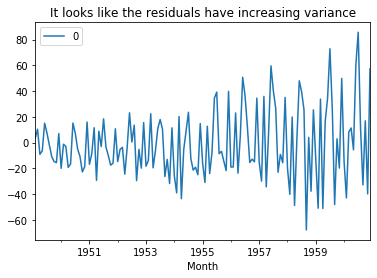

In [34]:
# plot residual errors to see if there is some trend not captured. 
 
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot()
plt.title("It looks like the residuals have increasing variance")

In [35]:
# SARIMAX stands for Seasonal Auto Regressive Integrated Moving Average with Exogenous 
# Arima does not take into account seasonal components.
# Adding them might help improve the model

from statsmodels.tsa.statespace.sarimax import SARIMAX

# We use the SARIMAX function like this
sarimax = SARIMAX(ts['#Passengers'], order = [5,1,1], seasonal_order = [])

IndexError: list index out of range

In [ ]:
# Again, look at the ACF and pACF of the data that has not been differenced
plot_acf(ts['#Passengers'].diff(12).dropna().diff(1).dropna())
plot_pacf(ts['#Passengers'].diff(12).dropna().diff(1).dropna())

In [36]:
# Looks like with a
sarimax = SARIMAX(ts['#Passengers'], order = [5,1,1], seasonal_order = [1, 1, 1,12])
sari_fit = sarimax.fit()

/Users/johnmaxbarry/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/johnmaxbarry/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [37]:
sari_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(5, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -502.055
Date:                            Fri, 03 Apr 2020   AIC                           1022.111
Time:                                    14:31:14   BIC                           1047.988
Sample:                                01-01-1949   HQIC                          1032.626
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5989      0.106      5.662      0.000       0.392       0.806
ar.L2          0.2654      0.151      1.755      0.079      -0.031       0.562
ar.L3         -0.0630      0.132     -0.476      0.634      -0.322       0.196
ar.L4         -0.0936      0.101     -0.923      0.356      -0.292       0.105
ar.L5          0.1177      0.104      1.134      0.257      -0.086       0.321
ma.L1         -0.9792      0.047    -20.971      0.000      -1.071      -0.888
ar.S.L12      -0.8364      0.293     -2.859      0.004      -1.410      -0.263
ma.S.L12       0.7214      0.374      1.928      0.054      -0.012       1.455
sigma2       123.9300     14.237      8.705      0.000      96.025     151.835
===================================================================================
Ljung-Box (Q):                       49.45   Jarque-Bera (JB):                16.86
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               2.50   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'That looks fairly normal')

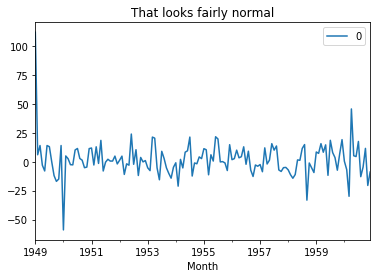

In [38]:
# Let's look at the residual plot for the SARIMA model
residuals = pd.DataFrame(sari_fit.resid)
residuals.plot()
plt.title('That looks fairly normal')

In [39]:
# We are able forecast out a few steps, but too many steps will not result in good predictions 
# since the previous values are not observed
yhat = sari_fit.forecast(steps=3)
yhat

1961-01-01    446.508140
1961-02-01    422.937067
1961-03-01    461.286356
Freq: MS, dtype: float64

In [40]:
# We can get predictions 
pred = sari_fit.get_prediction(start=pd.to_datetime('1960-01-01'), dynamic=False)
pred_conf = pred.conf_int()

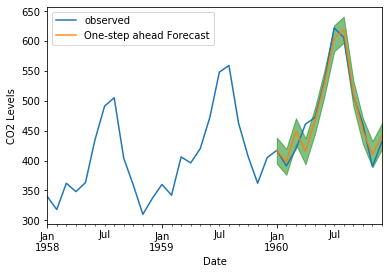

In [41]:
# Plot real vs predicted values

# Plot observed values
ax = ts['#Passengers']['1958-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [42]:
# We can now look at the MSE to evaluate our model
predicted = pred.predicted_mean
y_true = ts['#Passengers']['1960-01-01':]
mse = (predicted-y_true)**2/(len(y_true)-1)
mse.sum()


382.1906101990365

In [43]:
# We can also use dynamic forecasting to use our models predictions as forecasts after a certain point
pred = sari_fit.get_prediction(start=pd.to_datetime('1960-01-01'), dynamic=True)
pred_conf = pred.conf_int()


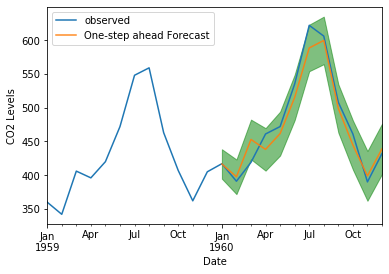

In [44]:
ax = ts['#Passengers']['1959-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [45]:
# Get forecast 500 steps ahead in future
prediction = sari_fit.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

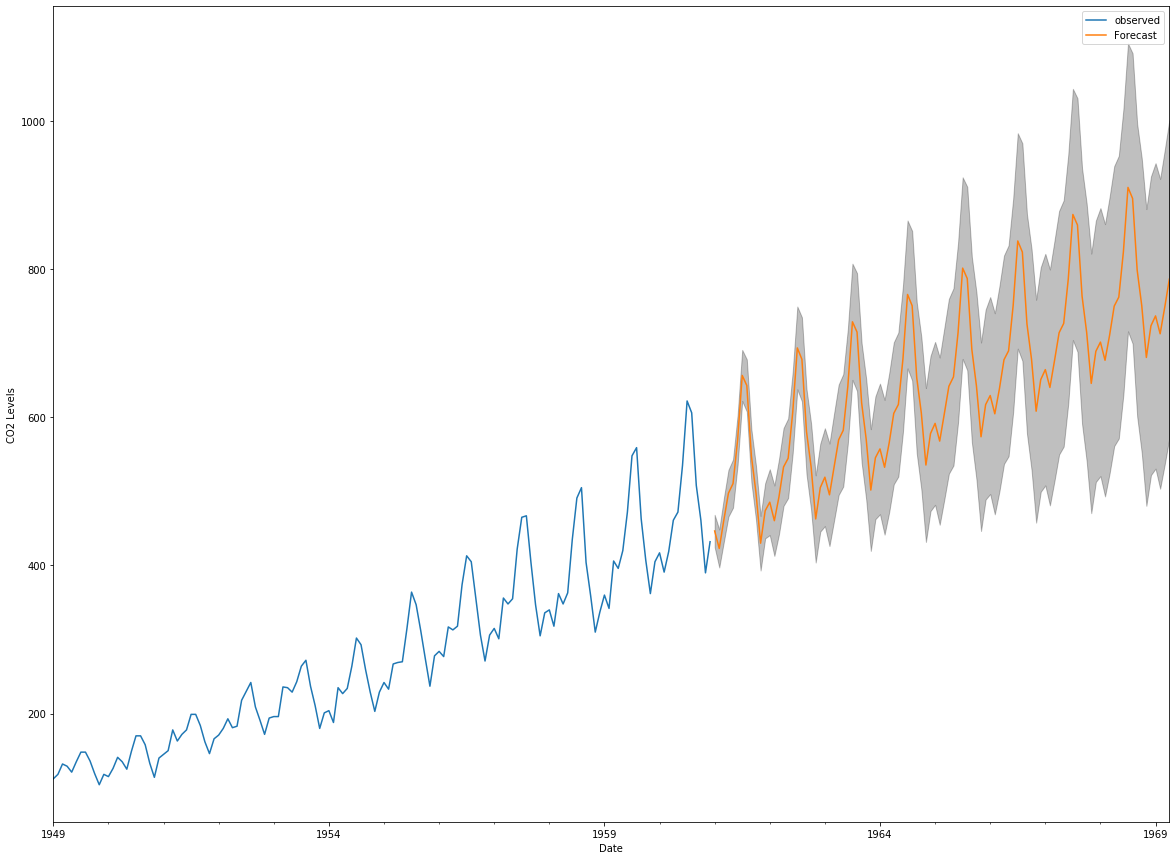

In [46]:
# Plot future predictions with confidence intervals
ax = ts['#Passengers'].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()